In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
%matplotlib inline

In [3]:
### 0. Device Setting Up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
### 1. Fetch Data
def prepare_data(ticker):
    
    data = yf.download(ticker, start="2015-01-01", end="2025-01-01", interval='1d')
    
    ### Log Return (Core Modification)
    data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))

    ### Enhancement of feature
    # Volatility
    data['Vol_20'] = data['Log_Returns'].rolling(20).std()
    # RSI
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rsi = gain / loss
    data['RSI'] = 100 - (100/(1+rsi))

    # Order
    #data['Vol_Change'] = data['Volume'].pct_change()

    data.dropna(inplace=True)
    return data

In [5]:
data = prepare_data("AAPL")

/tmp/ipykernel_3216059/3801367112.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01", interval='1d')
[*********************100%***********************]  1 of 1 completed


In [6]:
feature_cols = ['Log_Returns', 'Vol_20', 'RSI']#, 'Vol_Change']
target_cols = 'Log_Returns'

In [7]:
### Split dataset
split = int(len(data) * 0.8)
train, test = data.iloc[:split].copy(), data.iloc[split:].copy()

In [8]:
### 2. Scaling
# neural network prefer data range to be [0,1]
scaler = StandardScaler()
train_data = scaler.fit_transform(train[feature_cols].values)
test_data = scaler.fit_transform(test[feature_cols].values)

In [9]:
### 3. Sliding Window
def create_sequence(data, seq_length, target_idx):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i+seq_length)] # input: last (seq_length) days
        y = data[i+seq_length, target_idx]     # output: the (seq_length)th day
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [10]:
SEQ_LENGTH = 60
target_idx = 0
X_train, y_train = create_sequence(train_data, SEQ_LENGTH, target_idx)
X_test, y_test = create_sequence(test_data, SEQ_LENGTH, target_idx)

In [11]:
X_train.shape,y_train.shape


((1936, 60, 3), (1936,))

In [12]:
X_test.shape,y_test.shape

((440, 60, 3), (440,))

In [13]:
### Convert to Torch tensor
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device).unsqueeze(1)

X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device).unsqueeze(1)

In [14]:
print(f"Shape: train {X_train.shape}, test {X_test.shape}")

Shape: train torch.Size([1936, 60, 3]), test torch.Size([440, 60, 3])


In [15]:
### 4. Create LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim,
                 num_layers, ouput_dim,
                 dropout=0.2):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        ### LSTM layer price seq to feature
        # dropout for avoid overfitting
        self.lstm = nn.LSTM(input_dim, hidden_dim, 
                            num_layers, batch_first=True,
                            dropout=dropout)
        ### Fully connected layer convert feature to price
        self.fc = nn.Linear(hidden_dim,ouput_dim)
    
    def forward(self, x):

        ### Forward propagation
        out, _ = self.lstm(x)

        ### Output
        out = self.fc(out[:, -1, :])
        return out

In [16]:
### Init model
input_dim = len(feature_cols)     ## Feature
hidden_dim = 64   ## Num of neurons
num_layers = 2    ## LSTM layers
output_dim = 1    ## Output price

model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim).to(device)
### 5. Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
from tqdm import tqdm

In [18]:
### 6. Training Loop
num_epochs = 50
losses = []

print("Start Training")
model.train()
for epoch in tqdm(range(num_epochs)):
    
    optimizer.zero_grad() # clean gradient

    output = model(X_train)
    loss = criterion(output, y_train)

    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

Start Training


 38%|███▊      | 19/50 [00:00<00:00, 49.42it/s]

Epoch [10/50], Loss: 1.013787
Epoch [20/50], Loss: 1.010586


 74%|███████▍  | 37/50 [00:00<00:00, 56.41it/s]

Epoch [30/50], Loss: 1.006211
Epoch [40/50], Loss: 0.998682


100%|██████████| 50/50 [00:00<00:00, 51.53it/s]

Epoch [50/50], Loss: 0.991694


In [19]:
### 7. Evaluation
model.eval()
with torch.no_grad():
    test_preds = model(X_test).cpu().numpy()
    # test_true = y_test.cpu().numpy()
    
### restore price to real 
## What we predict is log return, we need to start from the first price in the test, then to real price
# Price_t = Price_{t-1} * exp(Predicted_Log_Ret)
#test_start_idx = split + SEQ_LENGTH
#initial_price = data["Close"].iloc[test_start_idx-1]

#predicted_prices = [initial_price]
#actual_prices = [initial_price]
mean_ret = scaler.mean_[0]
std_ret = scaler.scale_[0]

In [20]:
pred_rets = test_preds * std_ret + mean_ret

In [32]:
actual_rets = y_test.cpu().numpy() * std_ret + mean_ret

In [23]:
# 获取对应的基准价格 (前一天的真实收盘价)
base_prices = test['Close'].values[SEQ_LENGTH-1 : -1]

# One-Step Prediction: 用昨天的真价格 * 预测的涨幅
pred_prices_1step = base_prices * np.exp(pred_rets.flatten())
actual_prices = test['Close'].values[SEQ_LENGTH:]

### Cumulatively restore price
for i in range(len(test_preds)):
    # 这里的 inverse_transform 很麻烦，因为 scaler 是对所有特征缩放的
    # 简单起见，我们在上面没有对 Target 单独缩放，而是直接用了 scaler 后的值
    # 在严谨的工程中，应该单独建立一个 scaler 给 target
    
    # 假设我们用 scaled data 直接近似 (为了演示逻辑，这里简化，实际需要反归一化)
    # 注意：这里的 pred_rets 是标准化后的，必须反标准化！
    # 下面这行是取 Log_Ret 列的均值和方差进行反算
    mean_ret = scaler.mean_[0]
    std_ret = scaler.scale_[0]

    real_pred_ret = test_preds[i][0] * std_ret + mean_ret
    real_true_ret = test_true[i][0] * std_ret + mean_ret

    next_pred_ret = predicted_prices[-1] * np.exp(real_pred_ret)
    next_true_ret = actual_prices[-1] * np.exp(real_true_ret)

    predicted_prices.append(next_pred_ret)
    actual_prices.append(next_true_ret)


In [28]:
pred_prices_1step_mean = pred_prices_1step.mean(axis=1)

In [29]:
pred_prices_1step_mean

array([162.96725413, 164.22236987, 163.68869464, 161.8406319 ,
       162.73007533, 160.13090563, 158.9153146 , 158.22354054,
       163.61951876, 163.27363938, 163.29337116, 164.51885101,
       165.66526617, 164.69674276, 163.08585882, 163.39221349,
       161.85050543, 161.8406319 , 166.43615077, 167.69123593,
       167.60226714, 166.56458313, 165.48735914, 163.84682403,
       171.53563256, 171.46647196, 169.75673041, 171.52574374,
       171.7135243 , 170.7832723 , 170.28843399, 170.28843399,
       170.90199925, 173.2375945 , 173.34643264, 172.39641828,
       169.78372214, 170.06079247, 171.19893892, 173.61364471,
       175.46430575, 175.41480053, 178.22538002, 179.07647563,
       177.72069875, 177.35450678, 175.9789217 , 178.70044069,
       179.08639501, 181.88707041, 181.41205559, 182.04541377,
       184.08409992, 183.00539337, 183.09445387, 182.05533316,
       185.06385715, 184.74717042, 183.35177713, 186.11289725,
       187.29056841, 187.62703278, 191.96168248, 190.46

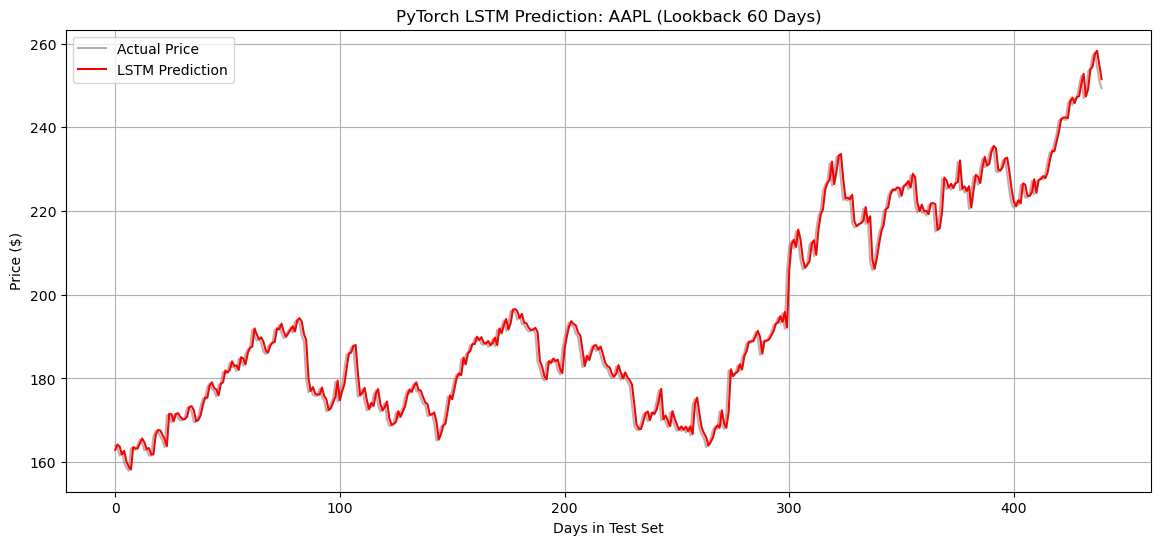

In [34]:
### 8. Visualization
plt.figure(figsize=(14,6))
plt.plot(actual_prices, label='Actual Price', 
         color='grey', alpha=0.6)
plt.plot(pred_prices_1step_mean, label='LSTM Prediction', 
         color='red', linewidth=1.5)
plt.title(f"PyTorch LSTM Prediction: AAPL (Lookback {SEQ_LENGTH} Days)")
plt.xlabel("Days in Test Set")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.savefig("Figure_1_LSTM_Prediction_Advanced_v2.png", dpi=300, bbox_inches='tight')
plt.show()

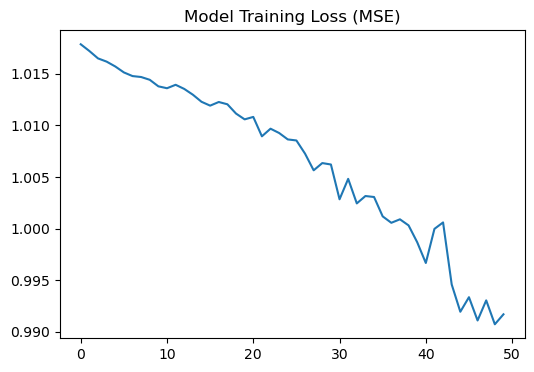

In [31]:
# Training loss
plt.figure(figsize=(6,4))
plt.plot(losses, label='Training Loss')
plt.title("Model Training Loss (MSE)")
#plt.savefig("Figure_2_LSTM_Loss.png", dpi=300, bbox_inches='tight')
plt.show()

In [33]:
direction_correct = np.sign(pred_rets) == np.sign(actual_rets)
print(f"Directional prediction: {np.mean(direction_correct):.2%}")

Directional prediction: 54.32%
